<center><h1>Han_Brandon_HW5</h1></center>
<br>
<br>

## 1. Decision Trees as Interpretable Models

Import packages

In [160]:
import pandas as pd
import os
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import export_text
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

### (a) Obtain Data

Get the Accute Inamations Data Set

In [161]:
data_path = '../data/diagnosis.data'


# Define column names based on .names file information
column_names = [
    'Temperature', 'Nausea', 'Lumbar_Pain', 'Urine_Pushing', 'Micturition_Pains', 
    'Urethra_Burning', 'Inflammation_Diagnosis', 'Nephritis_Diagnosis'
]

data = pd.read_csv(data_path, header=None, names=column_names, delimiter='\t', encoding='utf-16')
print(data.head())



   Temperature Nausea Lumbar_Pain Urine_Pushing Micturition_Pains  \
0         35.5     no         yes            no                no   
1         35.9     no          no           yes               yes   
2         35.9     no         yes            no                no   
3         36.0     no          no           yes               yes   
4         36.0     no         yes            no                no   

  Urethra_Burning Inflammation_Diagnosis Nephritis_Diagnosis  
0              no                     no                  no  
1             yes                    yes                  no  
2              no                     no                  no  
3             yes                    yes                  no  
4              no                     no                  no  


### (b) Build a decision tree

C:\Users\Brandon\AppData\Local\Temp\ipykernel_6568\2096479085.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace({'yes': 1, 'no': 0})


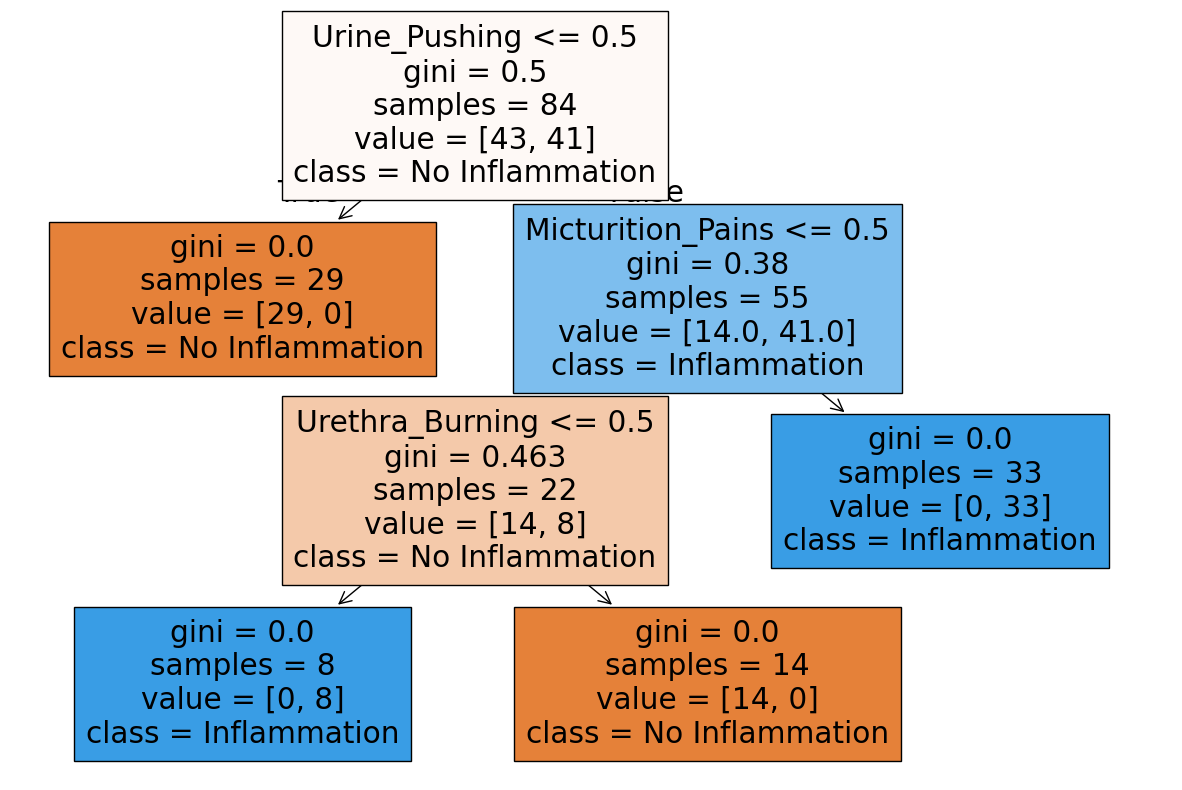

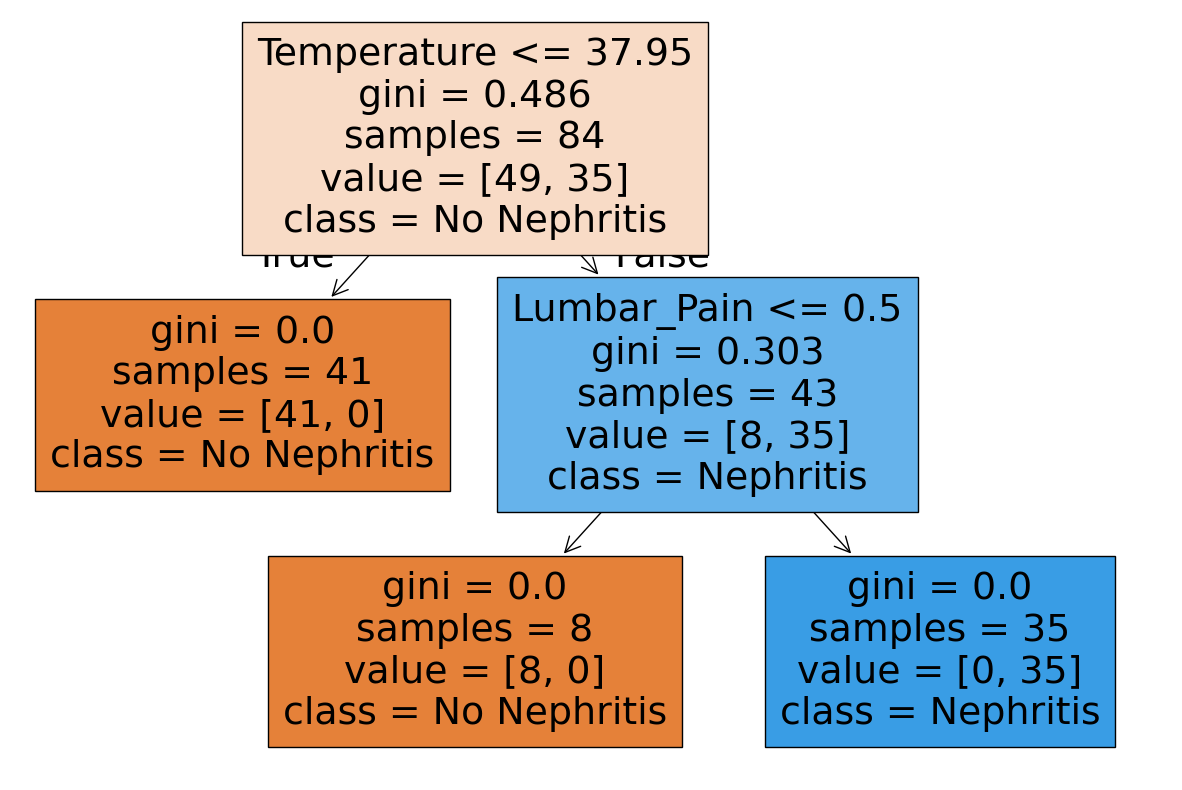

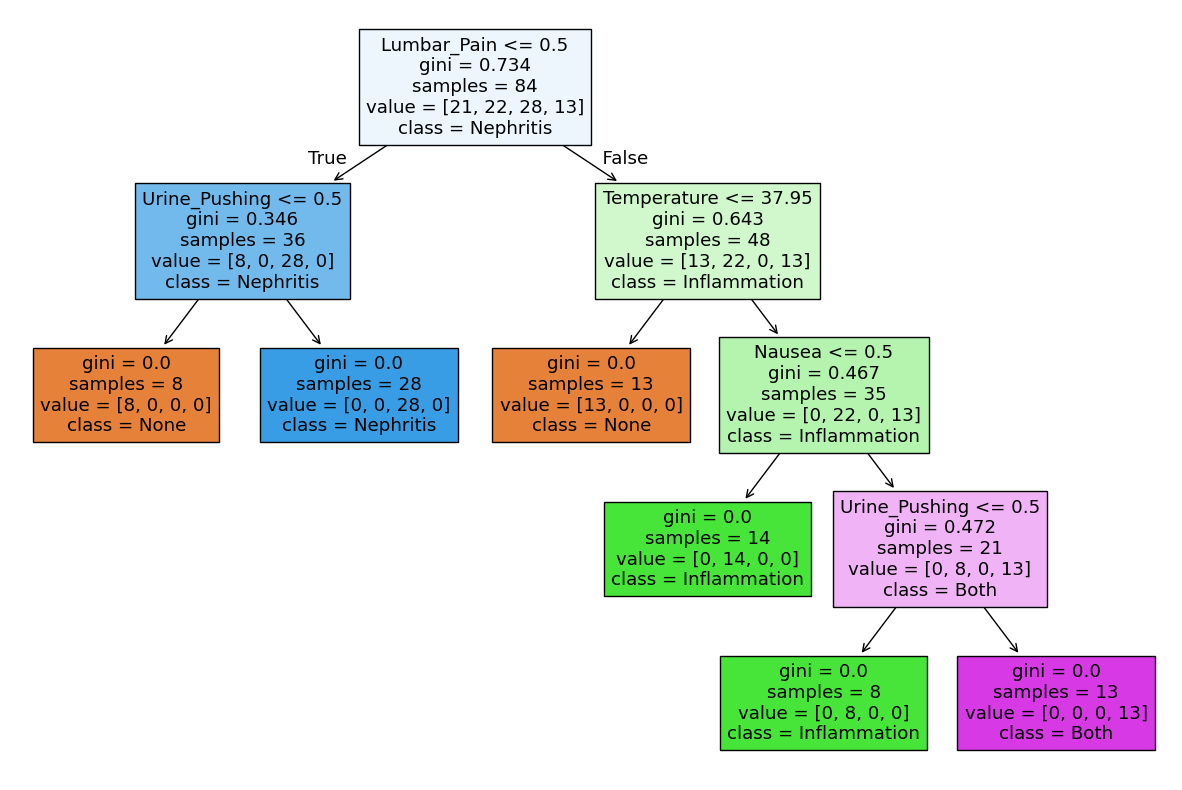

In [162]:
# Convert 'yes'/'no' to 1/0 in the target column and features
data = data.replace({'yes': 1, 'no': 0})

X = data[['Temperature', 'Nausea', 'Lumbar_Pain', 'Urine_Pushing', 'Micturition_Pains', 'Urethra_Burning']]
y_inflammation = data['Inflammation_Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y_inflammation, test_size=0.3, random_state=42)
tree_inflammation = DecisionTreeClassifier(random_state=42)
tree_inflammation.fit(X_train, y_train)

# Plot the tree
plt.figure(figsize=(15, 10))
plot_tree(tree_inflammation, filled=True, feature_names=X.columns, class_names=['No Inflammation', 'Inflammation'])
plt.show()

y_nephritis = data['Nephritis_Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y_nephritis, test_size=0.3, random_state=42)
tree_nephritis = DecisionTreeClassifier(random_state=42)
tree_nephritis.fit(X_train, y_train)

# Plot the tree
plt.figure(figsize=(15, 10))
plot_tree(tree_nephritis, filled=True, feature_names=X.columns, class_names=['No Nephritis', 'Nephritis'])
plt.show()

# Combine inflammation and nephritis into a single multi-class target
data['Combined_Diagnosis'] = (
    data['Inflammation_Diagnosis'] * 2 + data['Nephritis_Diagnosis']
)

y_combined = data['Combined_Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y_combined, test_size=0.3, random_state=42)
tree_combined = DecisionTreeClassifier(random_state=42)
tree_combined.fit(X_train, y_train)

# Plot the tree
plt.figure(figsize=(15, 10))
plot_tree(tree_combined, filled=True, feature_names=X.columns, class_names=['None', 'Inflammation', 'Nephritis', 'Both'])
plt.show()



### (c) Convert the decision rules

In [163]:
rules_inflammation = export_text(tree_inflammation, feature_names=list(X.columns))
print(rules_inflammation)

rules_nephritis = export_text(tree_nephritis, feature_names=list(X.columns))
print(rules_nephritis)

rules_combined = export_text(tree_combined, feature_names=list(X.columns))
print(rules_combined)

|--- Urine_Pushing <= 0.50
|   |--- class: 0
|--- Urine_Pushing >  0.50
|   |--- Micturition_Pains <= 0.50
|   |   |--- Urethra_Burning <= 0.50
|   |   |   |--- class: 1
|   |   |--- Urethra_Burning >  0.50
|   |   |   |--- class: 0
|   |--- Micturition_Pains >  0.50
|   |   |--- class: 1

|--- Temperature <= 37.95
|   |--- class: 0
|--- Temperature >  37.95
|   |--- Lumbar_Pain <= 0.50
|   |   |--- class: 0
|   |--- Lumbar_Pain >  0.50
|   |   |--- class: 1

|--- Lumbar_Pain <= 0.50
|   |--- Urine_Pushing <= 0.50
|   |   |--- class: 0
|   |--- Urine_Pushing >  0.50
|   |   |--- class: 2
|--- Lumbar_Pain >  0.50
|   |--- Temperature <= 37.95
|   |   |--- class: 0
|   |--- Temperature >  37.95
|   |   |--- Nausea <= 0.50
|   |   |   |--- class: 1
|   |   |--- Nausea >  0.50
|   |   |   |--- Urine_Pushing <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- Urine_Pushing >  0.50
|   |   |   |   |--- class: 3



### (d) Use cost-complexity pruning to find a minimal decision tree and a set of decisionrules with high interpretability

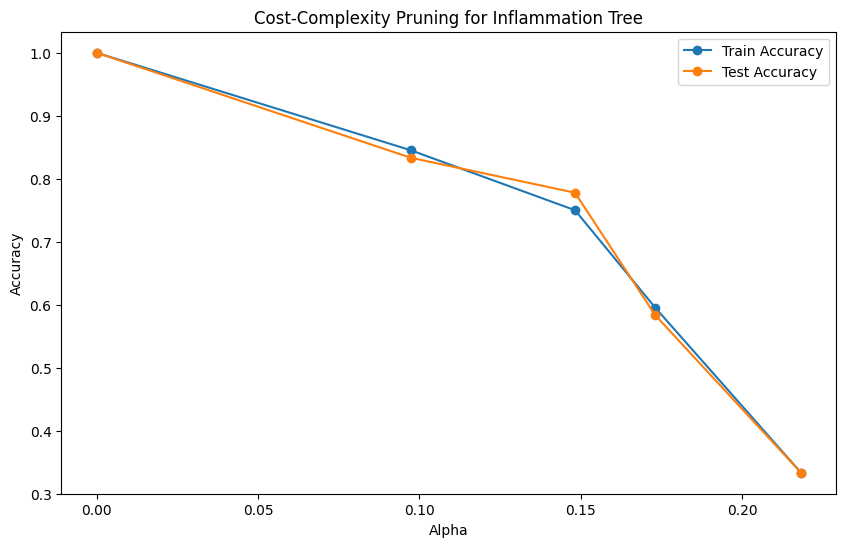

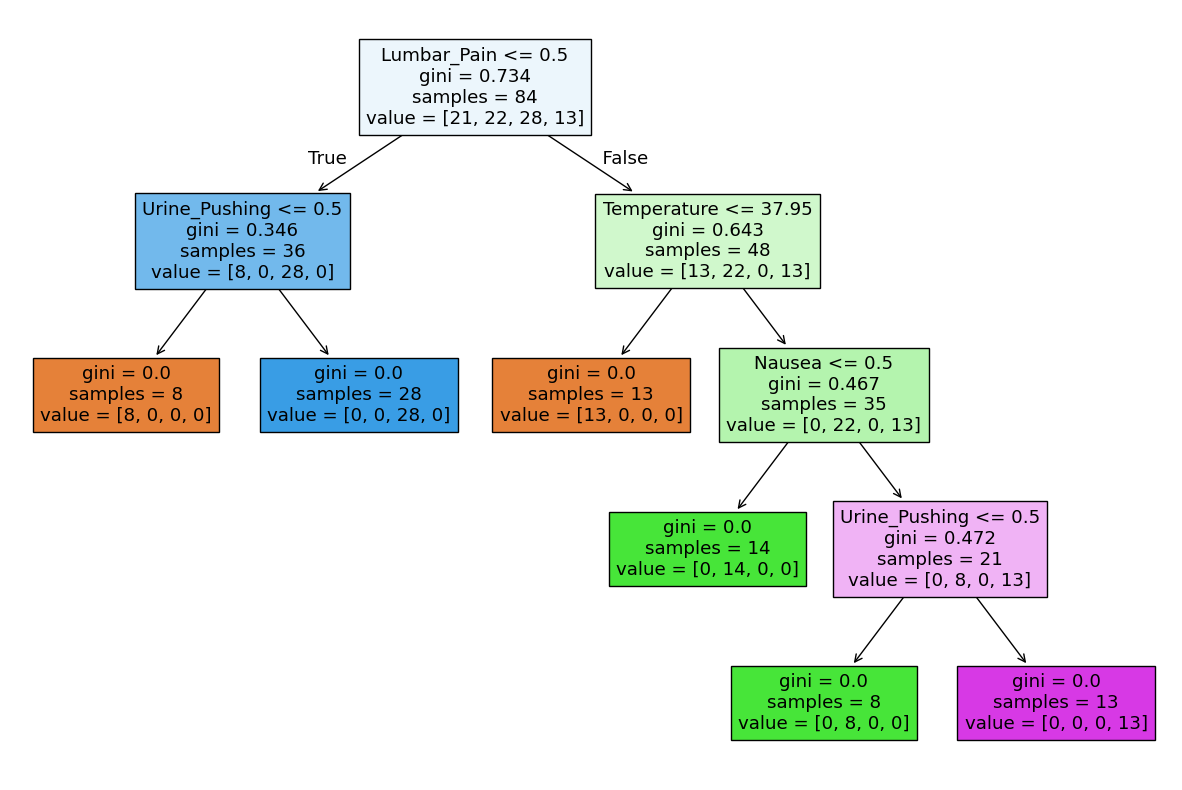

In [164]:
# For the inflammation tree
path_inflammation = tree_inflammation.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas_inflammation, impurities_inflammation = path_inflammation.ccp_alphas, path_inflammation.impurities

# Empty lists to store pruned trees and their accuracies for inflammation
pruned_trees_inflammation = []
train_scores_inflammation = []
test_scores_inflammation = []

# Train pruned trees
for alpha in ccp_alphas_inflammation:
    pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    pruned_tree.fit(X_train, y_train)
    pruned_trees_inflammation.append(pruned_tree)
    train_scores_inflammation.append(pruned_tree.score(X_train, y_train))
    test_scores_inflammation.append(pruned_tree.score(X_test, y_test))

# Plot for inflammation tree
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas_inflammation, train_scores_inflammation, label="Train Accuracy", marker='o')
plt.plot(ccp_alphas_inflammation, test_scores_inflammation, label="Test Accuracy", marker='o')
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Cost-Complexity Pruning for Inflammation Tree")
plt.legend()
plt.show()

# Select the pruned tree with the optimal ccp_alpha based on the highest test accuracy
optimal_index = np.argmax(test_scores_inflammation)
optimal_alpha = ccp_alphas_inflammation[optimal_index]
pruned_tree_inflammation = DecisionTreeClassifier(random_state=42, ccp_alpha=optimal_alpha)
pruned_tree_inflammation.fit(X_train, y_train)

# Plot the pruned tree without class names
plt.figure(figsize=(15, 10))
plot_tree(pruned_tree_inflammation, filled=True, feature_names=list(X.columns))
plt.show()



## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [165]:
data = pd.read_csv('../data/communities.data')  

# Separate features and target variable (assuming the target is in the last column)
X = data.iloc[:, :-1]  # All columns except the last
y = data.iloc[:, -1]   # Target variable (last column)

# Split the data into training (first 1495 rows) and test set (remaining rows)
X_train = X.iloc[:1495]
y_train = y.iloc[:1495]
X_test = X.iloc[1495:]
y_test = y.iloc[1495:]



### (b) Missing values

In [166]:
# List of non-predictive columns to drop
non_predictive_columns = ['state', 'county', 'community', 'communityname', 'fold']

# Drop non-predictive columns from the original data before splitting into train and test
X = X.drop(columns=non_predictive_columns, errors='ignore')

# Select only numeric columns and update feature names
X = X.select_dtypes(include=[np.number])
feature_names = X.columns  

X_train = X.iloc[:1495, :]
X_test = X.iloc[1495:, :]
y_train = y.iloc[:1495]
y_test = y.iloc[1495:]

imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Convert imputed data back to DataFrames with updated feature names
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

param_grid = {
    'alpha': [0, 0.01, 0.1, 1, 10],  
    'learning_rate': [0.1],      
    'n_estimators': [100] 
}

# Initialize the XGBRegressor with L1 penalty
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree')

# Set up GridSearchCV to find the best alpha
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_xgb_model = grid_search.best_estimator_

# Make predictions and calculate test error (MSE)
y_pred = best_xgb_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Test Mean Squared Error: {test_mse}")


Best alpha: 1
Test Mean Squared Error: 0.016724330996055456


### (c) Plot a correlation matrix

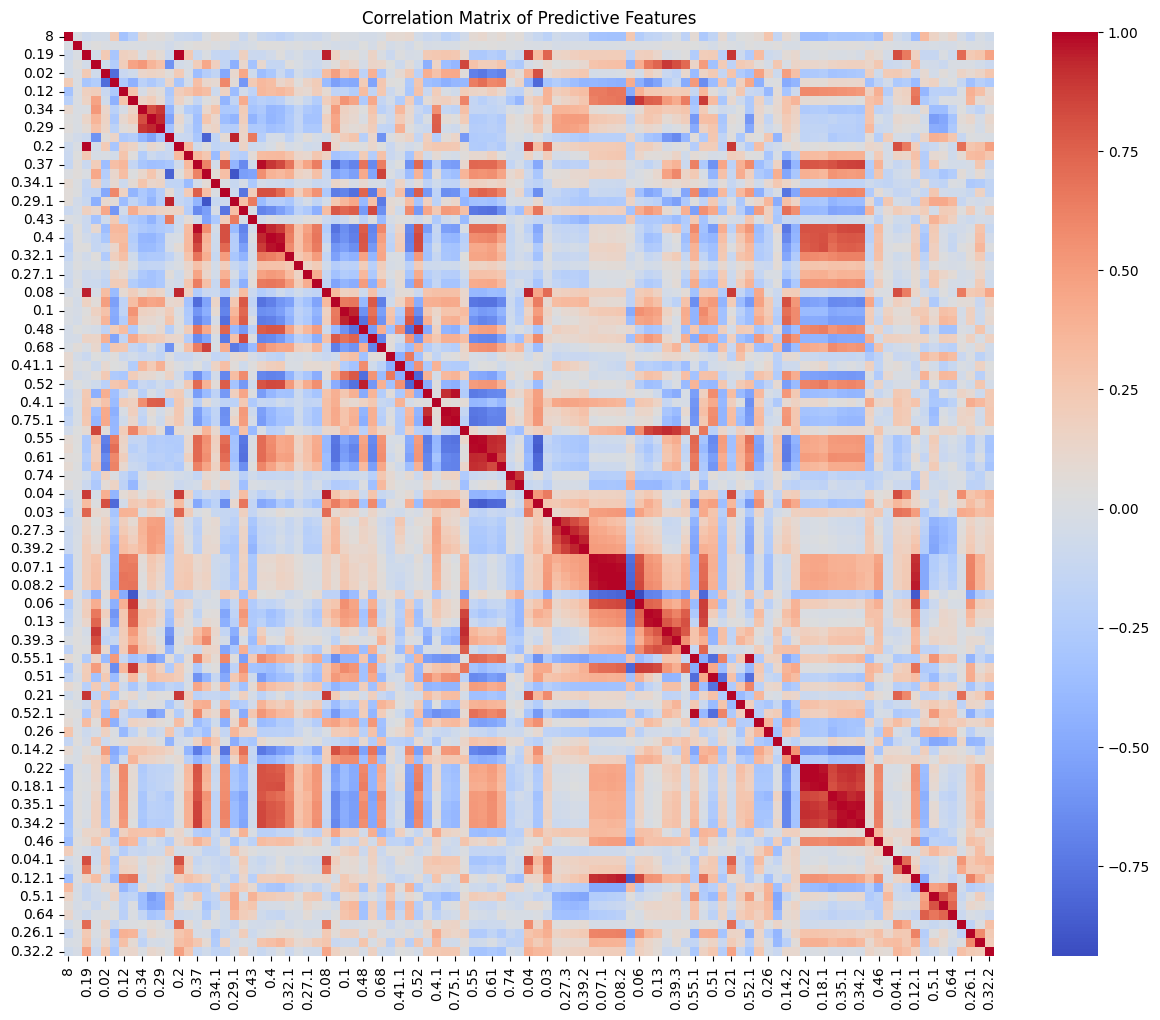

In [167]:
# List of non-predictive columns to drop
non_predictive_columns = ['state', 'county', 'community', 'communityname', 'fold']
predictive_X = X.drop(columns=non_predictive_columns, errors='ignore')
numeric_X = predictive_X.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_X.corr()
plt.figure(figsize=(15, 12))  
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", cbar=True, fmt=".2f") 
plt.title("Correlation Matrix of Predictive Features")
plt.show()


### (d) Calculate the Coefficient of Variation CV

In [168]:
# Calculate the mean and standard deviation 
feature_means = X.mean()  # Mean for each feature
feature_std_devs = X.std()  # Standard deviation for each feature

# Calculate the Coefficient of Variation (CV) and set feature names as the index
cv_values = feature_std_devs / feature_means  # Calculate CV
cv_values.index = X.columns  # Ensure feature names are used

# Sort CV values in descending order and display
cv_values = cv_values.sort_values(ascending=False)
print("Coefficient of Variation (CV) for each feature:\n", cv_values)


Coefficient of Variation (CV) for each feature:
 0         4.406541
0.04.1    3.486974
0.04      2.995100
0.03      2.901222
0.32.2    2.558424
            ...   
0.35      0.316926
0.64      0.304313
0.47      0.290757
0.89      0.288750
0.71      0.269713
Length: 101, dtype: float64


### (e) Scatter plots and box plots for highest CV features

Top 11 Features with Highest CV:
 0         4.406541
0.04.1    3.486974
0.04      2.995100
0.03      2.901222
0.32.2    2.558424
0.08      2.306038
0.19      2.205998
0.2       2.003814
0.21      1.960592
0.12.2    1.679054
0.17      1.614824
dtype: float64


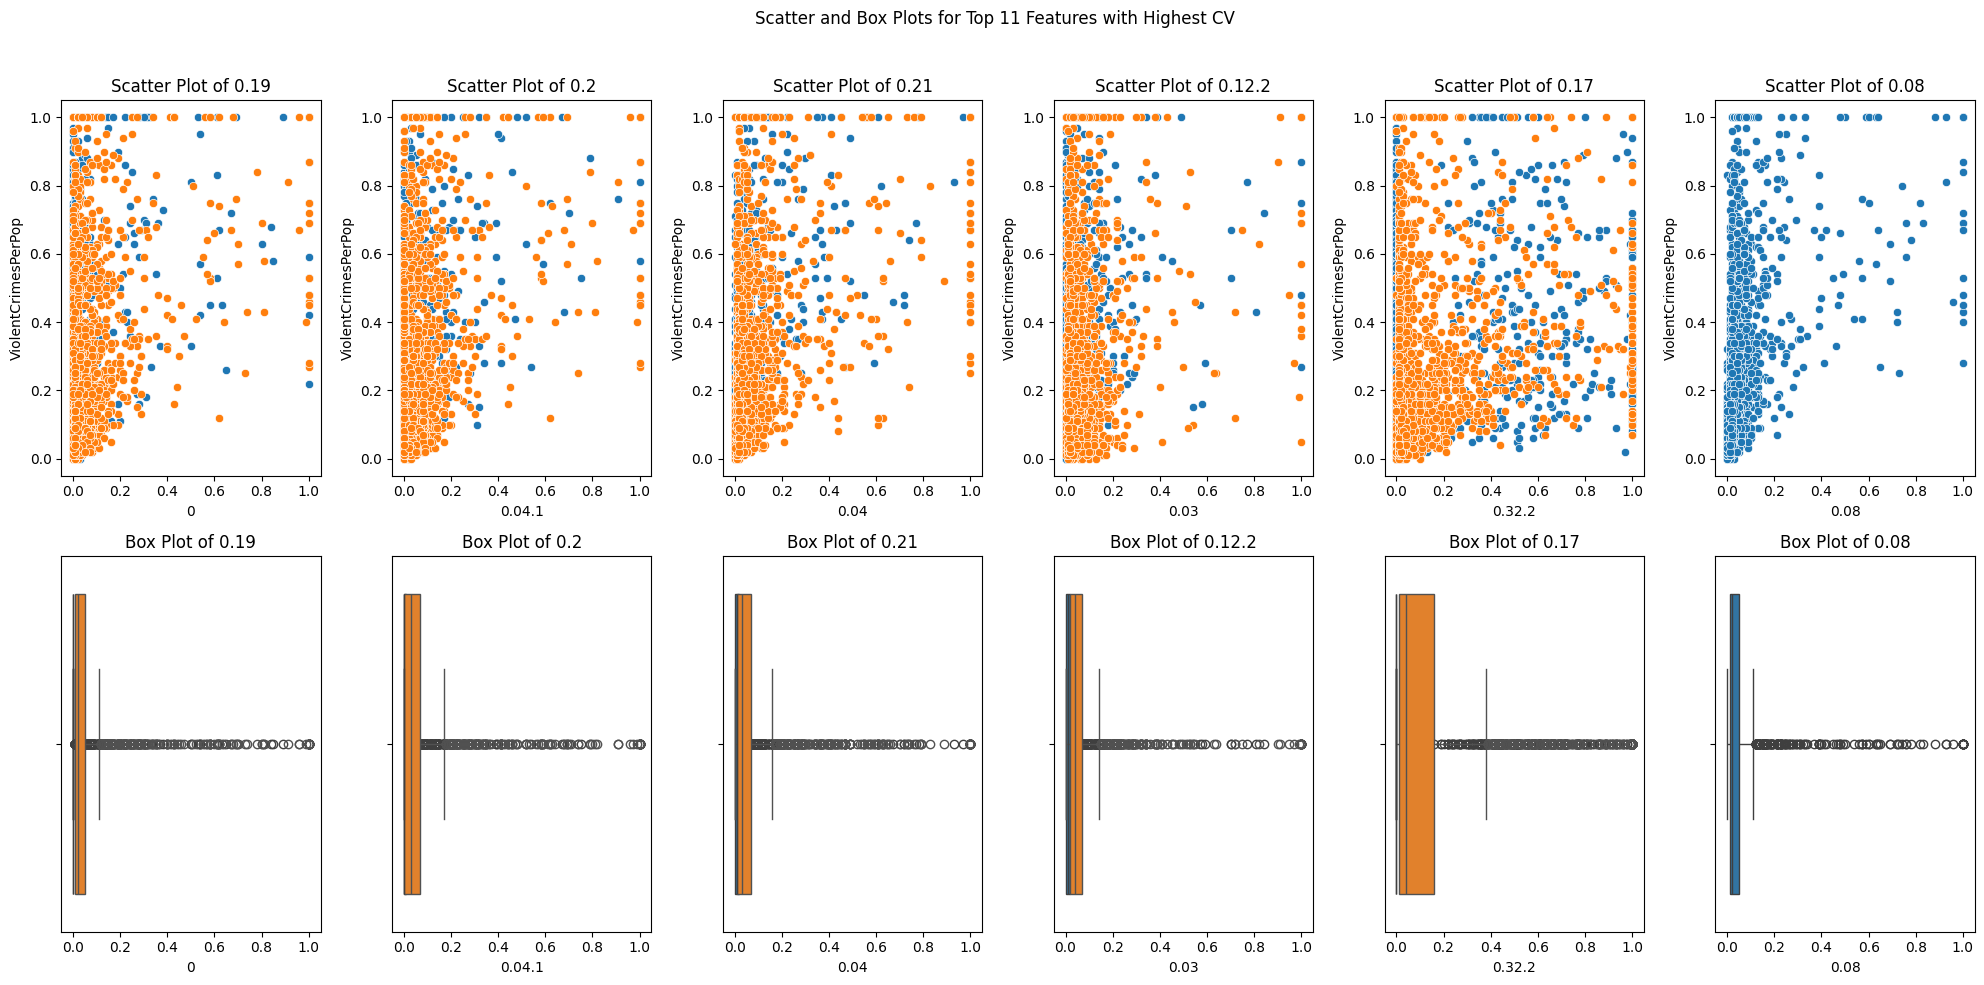

In [169]:
# Select the top 11 features with the highest CV values
top_cv_features = cv_values.head(11)
print("Top 11 Features with Highest CV:\n", top_cv_features)

X_visualization = X.copy()
X_visualization['ViolentCrimesPerPop'] = y 

fig, axes = plt.subplots(2, len(top_cv_features) // 2 + 1, figsize=(20, 10))
fig.suptitle("Scatter and Box Plots for Top 11 Features with Highest CV")

for i, feature in enumerate(top_cv_features.index):
    # Scatter plot of each feature against `ViolentCrimesPerPop`
    sns.scatterplot(data=X_visualization, x=feature, y='ViolentCrimesPerPop', ax=axes[0, i % (len(top_cv_features) // 2 + 1)])
    axes[0, i % (len(top_cv_features) // 2 + 1)].set_title(f'Scatter Plot of {feature}')
    
    # Box plot of each feature
    sns.boxplot(x=X_visualization[feature], ax=axes[1, i % (len(top_cv_features) // 2 + 1)])
    axes[1, i % (len(top_cv_features) // 2 + 1)].set_title(f'Box Plot of {feature}')

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()


### (f) Fit a linear model

In [170]:
# Fit a linear regression model on the training data
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_linear = linear_model.predict(X_test)

# Calculate the mean squared error (MSE) on the test set
test_mse_linear = mean_squared_error(y_test, y_pred_linear)

# Display the test error
print(f"Test Mean Squared Error for Linear Regression: {test_mse_linear}")

Test Mean Squared Error for Linear Regression: 0.017796138155165956


### (g) Fit a ridge regression model

In [171]:
# Define the parameter grid for lambda (alpha) in ridge regression
param_grid_ridge = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Set up GridSearchCV to find the best alpha (lambda) value using cross-validation
ridge_model = Ridge()
grid_search_ridge = GridSearchCV(estimator=ridge_model, param_grid=param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train, y_train)

# Get the best model from cross-validation
best_ridge_model = grid_search_ridge.best_estimator_

# Make predictions on the test data
y_pred_ridge = best_ridge_model.predict(X_test)

# Calculate the test mean squared error (MSE)
test_mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print(f"Best alpha (lambda) for Ridge Regression: {grid_search_ridge.best_params_['alpha']}")
print(f"Test Mean Squared Error for Ridge Regression: {test_mse_ridge}")

Best alpha (lambda) for Ridge Regression: 1
Test Mean Squared Error for Ridge Regression: 0.017450999758400965


### (h) Fit a LASSO model

In [172]:
param_grid_lasso = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Set up GridSearchCV to find the best alpha (lambda) value using cross-validation
lasso_model = Lasso(max_iter=10000)
grid_search_lasso = GridSearchCV(estimator=lasso_model, param_grid=param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train, y_train)

# Get the best model from cross-validation
best_lasso_model = grid_search_lasso.best_estimator_

# Make predictions on the test data
y_pred_lasso = best_lasso_model.predict(X_test)

# Calculate the test mean squared error (MSE)
test_mse_lasso = mean_squared_error(y_test, y_pred_lasso)

# Identify the selected features
selected_features = X_train.columns[best_lasso_model.coef_ != 0]

# Display the best lambda, test error, and selected features
print(f"Best alpha (lambda) for LASSO Regression: {grid_search_lasso.best_params_['alpha']}")
print(f"Test Mean Squared Error for LASSO Regression: {test_mse_lasso}")
print(f"Selected Features: {selected_features.tolist()}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Run GridSearchCV on standardized features
grid_search_lasso.fit(X_train_scaled, y_train)
best_lasso_model_scaled = grid_search_lasso.best_estimator_
y_pred_lasso_scaled = best_lasso_model_scaled.predict(X_test_scaled)
test_mse_lasso_scaled = mean_squared_error(y_test, y_pred_lasso_scaled)
selected_features_scaled = X_train.columns[best_lasso_model_scaled.coef_ != 0]

print("\nWith Standardized Features:")
print(f"Best alpha (lambda) for LASSO Regression: {grid_search_lasso.best_params_['alpha']}")
print(f"Test Mean Squared Error for LASSO Regression with Standardized Features: {test_mse_lasso_scaled}")
print(f"Selected Features with Standardized Features: {selected_features_scaled.tolist()}")

Best alpha (lambda) for LASSO Regression: 0.01
Test Mean Squared Error for LASSO Regression: 0.0202252191568792
Selected Features: ['8', '1', '0.02', '0.9', '0.59', '0.14']

With Standardized Features:
Best alpha (lambda) for LASSO Regression: 0.01
Test Mean Squared Error for LASSO Regression with Standardized Features: 0.017088051406559026
Selected Features with Standardized Features: ['8', '0.02', '0.9', '1.1', '0.68.1', '0.59', '0.76', '0.14', '0.09', '0.21', '0.71', '0.05', '0']


### (i) Fit a PCR model

In [173]:
n_components = list(range(1, min(X_train.shape[1], 50) + 1))  # limiting max components to 50 for efficiency

pcr_scores = []

# Iterate over possible numbers of components
for n in n_components:
    # Create a pipeline with PCA followed by Linear Regression
    pcr_pipeline = Pipeline([
        ('pca', PCA(n_components=n)),
        ('linear_regression', LinearRegression())
    ])
    
    scores = cross_val_score(pcr_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    pcr_scores.append(np.mean(scores))

# Find the number of components that gives the best cross-validation score
best_n_components = n_components[np.argmax(pcr_scores)]
print(f"Optimal number of principal components: {best_n_components}")

# Fit the final PCR model with the best number of components
best_pcr_pipeline = Pipeline([
    ('pca', PCA(n_components=best_n_components)),
    ('linear_regression', LinearRegression())
])

# Train on the full training set and evaluate on the test set
best_pcr_pipeline.fit(X_train, y_train)
y_pred_pcr = best_pcr_pipeline.predict(X_test)
test_mse_pcr = mean_squared_error(y_test, y_pred_pcr)

print(f"Test Mean Squared Error for PCR with {best_n_components} components: {test_mse_pcr}")

Optimal number of principal components: 50
Test Mean Squared Error for PCR with 50 components: 0.017947543939778262


### (j) Fit a boosting tree

In [174]:
# Set up the parameter grid for alpha (L1 regularization term)
param_grid = {
    'alpha': [0, 0.01, 0.1, 1, 10],  
    'learning_rate': [0.1],          # Default learning rate
    'n_estimators': [100]            
}

# Initialize the XGBRegressor with L1 penalty
xgb_model = XGBRegressor(objective='reg:squarederror', booster='gbtree')

# Set up GridSearchCV to find the best alpha
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_xgb_model = grid_search.best_estimator_

# Make predictions and calculate test error (MSE)
y_pred = best_xgb_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)

print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Test Mean Squared Error: {test_mse}")

Best alpha: 1
Test Mean Squared Error: 0.016724330996055456
